In [1]:
import json

import albumentations as A
import cv2
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
from skimage import io

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
def get_patch(annotation):
    patch = patches.Rectangle((annotation[0], annotation[1]), annotation[2], annotation[3], edgecolor='red', fill=False)
    return patch

def get_text_loc(annotation):
    return (annotation[0], annotation[1]-30)

def draw_bbox(frame, boxes, labels):
    '''
    Draw bounding box
    '''
    for box, label in zip(boxes, labels):
        # draw rectangle on frame
        box = list(map(int, box))
        # color_idx = [int(k) for k, v in label_list.items() if v == label][0]
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), [255, 0, 255], thickness=4) # palette[color_idx], thickness=4)

        # show scores and labels
        (w1, h1), _ = cv2.getTextSize(str(label), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)
        
        cv2.rectangle(frame, (box[0], box[1]-10-h1), (box[0]+w1, box[1]), [255, 0, 255], -1) # palette[color_idx], -1)
        cv2.putText(frame, str(label), (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv2.LINE_AA)
    return frame

In [4]:
anno_root = '/opt/ml/data/data/eval/eval.json'
data_dir = './data/eval'

coco = COCO(anno_root)

with open(anno_root, 'r') as f:
    root = json.load(f)

# Basic High Level Information
n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

# print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Number of images:  29759
Number of bounding boxes:  64463
Number of classes:  38
Max min avg height:  645 78 409
Max min avg width:  1619 67 494


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


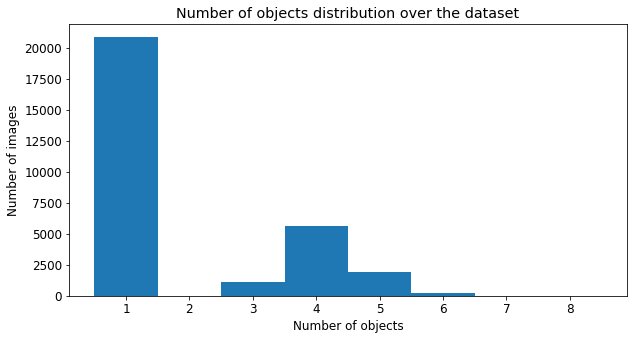

Number of images having atleast one box:  29759
Min number of boxes per image:  1
Max number of boxes per image:  7
Avg number of boxes per image:  2


In [5]:
# Objects per image distribution
img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

out = pd.cut(nboxes_list, bins=np.arange(1,max_nboxes+2,1), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0]+1 for i in labels]
# ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, width=1) # tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

In [7]:
import json

import numpy as np
from pycocotools.coco import COCO
from tqdm import tqdm

file_name = '/opt/ml/data/data/train/full_train.json'
# file_name = 'data/eval/eval.json'
print(f'start open file : {file_name}')
with open(file_name) as json_file:
    source_anns = json.load(json_file)

coco = COCO(file_name)

print(f'open file success!')
print(source_anns.keys())
source_images = source_anns['images']
source_categories = source_anns['categories']
source_annotations = source_anns['annotations']
print('data length : ', len(source_images))

cat_lst = list()
for cat in source_categories:
    cat_lst.append((cat['id'], cat['name']))
cat_lst.sort(key=lambda x: x[0])
cat_lst


start open file : /opt/ml/data/data/train/full_train.json
loading annotations into memory...
Done (t=2.69s)
creating index...
index created!
open file success!
dict_keys(['images', 'categories', 'annotations'])
data length :  137415


[(0, 'Aerosol'),
 (1, 'Alcohol'),
 (2, 'Awl'),
 (3, 'Axe'),
 (4, 'Bat'),
 (5, 'Battery'),
 (6, 'Bullet'),
 (7, 'Firecracker'),
 (8, 'Gun'),
 (9, 'GunParts'),
 (10, 'Hammer'),
 (11, 'HandCuffs'),
 (12, 'HDD'),
 (13, 'Knife'),
 (14, 'Laptop'),
 (15, 'Lighter'),
 (16, 'Liquid'),
 (17, 'Match'),
 (18, 'MetalPipe'),
 (19, 'NailClippers'),
 (20, 'PrtableGas'),
 (21, 'Saw'),
 (22, 'Scissors'),
 (23, 'Screwdriver'),
 (24, 'SmartPhone'),
 (25, 'SolidFuel'),
 (26, 'Spanner'),
 (27, 'SSD'),
 (28, 'SupplymentaryBattery'),
 (29, 'TabletPC'),
 (30, 'Thinner'),
 (31, 'USB'),
 (32, 'ZippoOil'),
 (33, 'Plier'),
 (34, 'Chisel'),
 (35, 'Electronic cigarettes'),
 (36, 'Electronic cigarettes(Liquid)'),
 (37, 'Throwing Knife')]

In [9]:
anno_root = '/opt/ml/data/data/eval/eval.json'
data_dir = './data/eval'

coco = COCO(anno_root)

ids = [866, 915, 916, 2456, 2679, 2923, 2962, 3705, 3709, 3826, 3827, 3838, 3839, 3862, 3863,
       4128, 4134, 4292, 4331, 4375, 4401, 4455, 4724, 4728, 4825, 4832, 4931, 4955, 5008, 5324,
       5389, 5401, 5439, 5442, 5443, 5608, 6396, 6397, 6438, 6440, 6441, 6521, 6611, 6620, 6623,
       6624, 6707, 6712, 6713, 6719, 6720, 6768, 6770, 6797, 6798, 6907, 6908, 6909, 6922, 6999,
       7000, 7320, 7705, 7900, 8383, 9183, 9697, 9698, 10965, 12929, 13069, 13186, 13555, 14577,
       14874, 15322, 15494, 15518, 15522, 15525, 15528, 15553, 15798, 20534, 20536, 20537, 
       20539, 20610, 22227, 24082, 24091, 25833, 25834, 25838, 25846, 25853, 25909, 25910, 
       26463, 26675, 26686, 29730]
images = coco.dataset["images"].copy()
image_paths, image_bboxes, image_labels, widths, heights = list(), list(), list(), list(), list()
for i in range(len(images)):
    if i in ids:
        image_info = coco.loadImgs(i)[0]
        image_paths.append(data_dir+image_info['path']+image_info['file_name'])
        
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = np.array([x['category_id'] for x in anns])

        image_bboxes.append(boxes)
        image_labels.append(labels)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [20]:
anno_root = '/opt/ml/data/data/train/full_train.json'
data_dir = '/opt/ml/data/data/train'

coco = COCO(anno_root)

images = coco.dataset["images"].copy()
image_paths, image_bboxes, image_labels, widths, heights = list(), list(), list(), list(), list()
for i in range(len(images)):
    if i in [1505, 1509, 1513, 1515, 1519, 1647, 1739, 2007, 2051, 2677, 3406, 3820, 4131, 4139, 4143, 4193]:
        image_info = coco.loadImgs(i)[0]
        image_paths.append(data_dir+image_info['path']+image_info['file_name'])
        
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = np.array([x['category_id'] for x in anns])

        image_bboxes.append(boxes)
        image_labels.append(labels)

loading annotations into memory...
Done (t=3.27s)
creating index...
index created!


In [21]:
len(image_paths)

16

IndexError: list index out of range

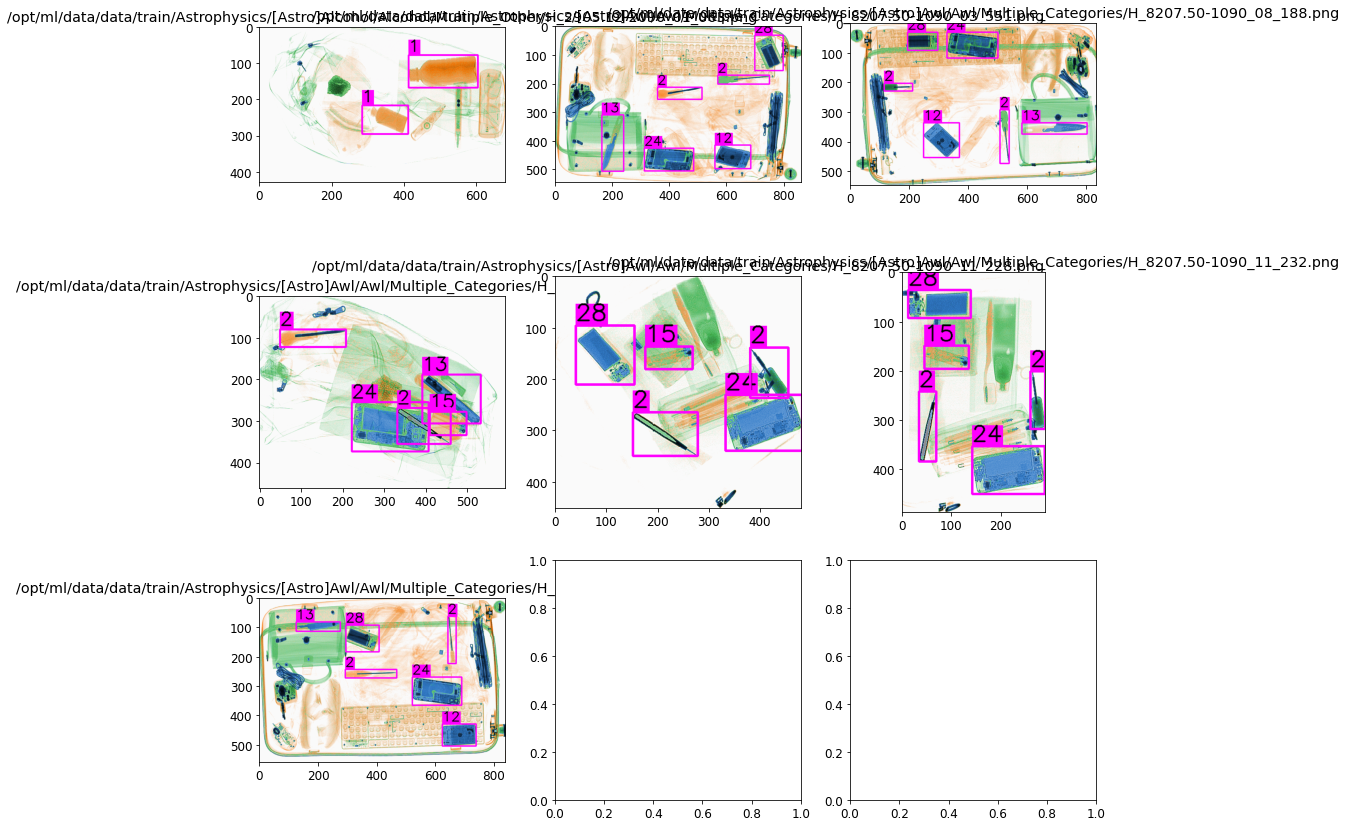

In [22]:
start = 0+9
frame_lst = []
path_lst = image_paths[start:start+9]
bbox_lst = image_bboxes[start:start+9]
label_lst = image_labels[start:start+9]

for i in range(len(path_lst)):
    frame = cv2.imread(path_lst[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = draw_bbox(frame, bbox_lst[i], label_lst[i])
    frame_lst.append(frame)

n, m = 3, 3
fig, axes = plt.subplots(n, m, figsize=(m*5, n*5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frame_lst[i])
    ax.set_title(path_lst[i])
plt.show()

In [23]:
len(image_paths)

16

In [24]:
widths.index(np.max(widths))

ValueError: zero-size array to reduction operation maximum which has no identity

In [25]:
np.max(widths)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
np.max(heights)

ValueError: zero-size array to reduction operation maximum which has no identity

In [26]:
image_labels[43]

IndexError: list index out of range

In [27]:
idx = 43
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame = draw_bbox(image, image_bboxes[idx], image_labels[idx])
plt.imshow(frame)
plt.show()

IndexError: list index out of range

IndexError: list index out of range

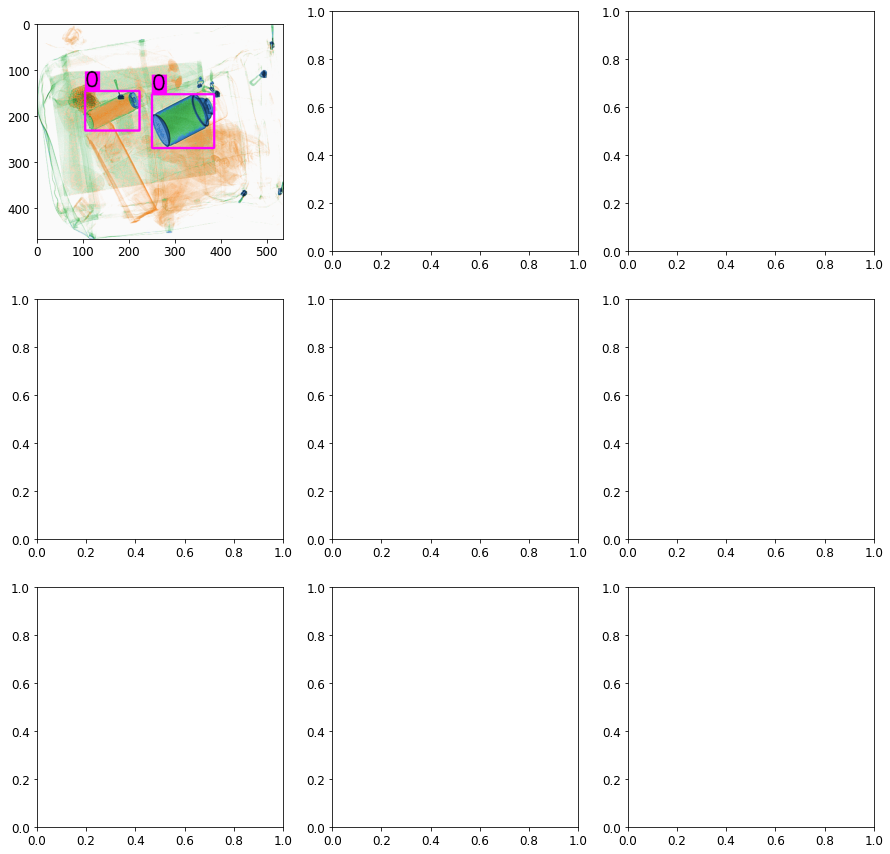

In [28]:
start = 0
frame_lst = []
path_lst = image_paths[start:start+9]
bbox_lst = image_bboxes[start:start+9]
label_lst = image_labels[start:start+9]
width_lst = widths[start:start+9]

for i in range(len(path_lst)):
    frame = cv2.imread(path_lst[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = draw_bbox(frame, bbox_lst[i], label_lst[i])
    frame_lst.append(frame)

n, m = 3, 3
fig, axes = plt.subplots(n, m, figsize=(m*5, n*5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frame_lst[i])
    ax.set_title('width : '+str(width_lst[i]))
plt.show()

In [30]:
idx = 72
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = A.Compose([
    A.PadIfNeeded(min_height=1500, min_width=1500, border_mode=cv2.BORDER_CONSTANT),
    A.Resize(1024, 1024)
    ])

frame = draw_bbox(image, image_bboxes[idx], image_labels[idx])
frame = transform(image=frame)['image']

print(frame.shape)

plt.imshow(frame)
plt.show()

IndexError: list index out of range

In [33]:
with open('/opt/ml/data/data/train/full_train.json', 'r') as json_file:
    source_anns = json.load(json_file)

source_categories = source_anns['categories']
source_categories

[{'id': 32, 'name': 'ZippoOil', 'supercategory': '', 'color': ''},
 {'id': 3, 'name': 'Axe', 'supercategory': '', 'color': ''},
 {'id': 22, 'name': 'Scissors', 'supercategory': '', 'color': ''},
 {'id': 33, 'name': 'Plier', 'supercategory': '', 'color': ''},
 {'id': 13, 'name': 'Knife', 'supercategory': '', 'color': ''},
 {'id': 26, 'name': 'Spanner', 'supercategory': '', 'color': ''},
 {'id': 28, 'name': 'SupplymentaryBattery', 'supercategory': '', 'color': ''},
 {'id': 8, 'name': 'Gun', 'supercategory': '', 'color': ''},
 {'id': 11, 'name': 'HandCuffs', 'supercategory': '', 'color': ''},
 {'id': 15, 'name': 'Lighter', 'supercategory': '', 'color': ''},
 {'id': 34, 'name': 'Chisel', 'supercategory': '', 'color': ''},
 {'id': 23, 'name': 'Screwdriver', 'supercategory': '', 'color': ''},
 {'id': 37, 'name': 'Throwing Knife', 'supercategory': '', 'color': ''},
 {'id': 1, 'name': 'Alcohol', 'supercategory': '', 'color': ''},
 {'id': 20, 'name': 'PrtableGas', 'supercategory': '', 'color': 

In [34]:
from collections import Counter

classes = []
for l in image_labels:
    for c in l:
        for cat in source_categories:
            if cat['id'] == c:
                class_name = cat['name']
                classes.append(class_name)
counts = Counter(classes)
counts


Counter({'Aerosol': 14,
         'Alcohol': 2,
         'Awl': 12,
         'Knife': 4,
         'SmartPhone': 6,
         'HDD': 3,
         'SupplymentaryBattery': 5,
         'Lighter': 3})

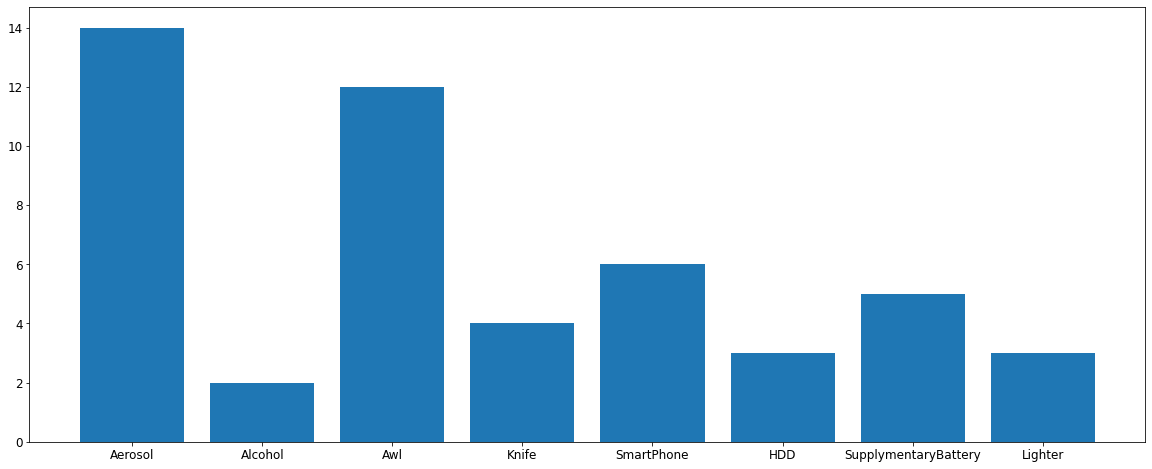

In [35]:
plt.rcParams["figure.figsize"] = (20, 8)
plt.bar([x for x in counts.keys()], counts.values())
plt.show()

In [50]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import json

from models.fasterrcnn import LitModel

annotation = '/opt/ml/data/data/train/full_train.json'
img_path = '/opt/ml/data/data/eval/Astrophysics/Aerosol/Multiple_Categories/H_8481.80-1090_01_699.png'
coco = COCO(annotation)

with open(annotation) as json_file:
    source_anns = json.load(json_file)

source_images = source_anns['images']
source_annotations = source_anns['annotations']

for img in source_images:
    if img['file_name'] == 'H_8481.80-1090_01_699.png':
        img_id = img['id']

answer = []
for anno in source_annotations:
    if anno['image_id'] == img_id:
        answer.append(anno)

ans_bbox = []
ans_label = []
for ans in answer:
    ans_bbox.append(ans['bbox'])
    ans_label.append(ans['category_id'])

pl.seed_everything(42)

chk_path = '/opt/ml/finalproject/saved_models/fcnn/pytorch_lightning/2ot1u35c/checkpoints/epoch=0-step=1309.ckpt'
model = LitModel().load_from_checkpoint(chk_path)
# model.eval()

# def read_img(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
#     img /= 255.0
#     return img

# def valid_transform():
#     return A.Compose([
#         A.PadIfNeeded(min_height=1500, min_width=1500, border_mode=cv2.BORDER_CONSTANT),
#         A.Resize(1024, 1024),
#         # A.CenterCrop(800, 800),
#         ToTensorV2()
#     ])


# image = read_img(img_path)
# image2 = (image * 255).astype(np.uint8).copy()

# transform = valid_transform()
# image = transform(image=image)['image']
# image = image.unsqueeze(dim=0)
# with torch.no_grad():
#     output = model(image)
#     results = []
#     labels = output[0]['labels'].detach().cpu().numpy()
#     scores = output[0]['scores'].detach().cpu().numpy()
#     boxes = output[0]['boxes'].detach().cpu().numpy()
#     indexes = np.where(scores > 0.4)

#     labels = labels[indexes]
#     scores = scores[indexes]
#     boxes = boxes[indexes]

# # print(labels)
# print('pred scores : ',scores)
# # print(boxes)

# image = image.squeeze(dim=0)
# image = image.permute(1, 2, 0).numpy()
# image= (image * 255).astype(np.uint8)

# plt.figure(figsize=(20, 20))
# for i in range(len(labels)):

#     box = list(map(int, boxes[i]))
#     cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (250, 0, 50), 4)

#     text = str(labels[i])
#     cv2.rectangle(image, (box[0], box[1] - 30), (box[0] + 100, box[1]), (250, 0, 50), -1)
#     cv2.putText(image, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0), 4, cv2.LINE_AA)

# plt.subplot(1, 2, 1)
# plt.imshow(image)

# for i in range(len(ans_label)):

#     box = list(map(int, ans_bbox[i]))
#     cv2.rectangle(image2, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), (250, 250, 50), 4)

#     text = str(ans_label[i])
#     cv2.rectangle(image2, (box[0], box[1] - 30), (box[0] + 100, box[1]), (250, 250, 50), -1)
#     cv2.putText(image2, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0), 4, cv2.LINE_AA)

# plt.subplot(1, 2, 2)
# plt.imshow(image2)


loading annotations into memory...


Exception ignored in: <function tqdm.__del__ at 0x7f1291d240d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/tqdm/std.py", line 1128, in __del__
  File "/opt/conda/lib/python3.8/site-packages/tqdm/notebook.py", line 261, in close
AttributeError: 'tqdm' object has no attribute 'sp'


Done (t=3.66s)
creating index...
index created!


Global seed set to 42
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [40]:
!pip install ipywidgets

     |████████████████████████████████| 121 kB 16.8 MB/s 
     |████████████████████████████████| 243 kB 75.7 MB/s 
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
     |████████████████████████████████| 1.6 MB 78.0 MB/s 
  Using cached jsonschema-4.2.1-py3-none-any.whl (69 kB)
     |████████████████████████████████| 9.9 MB 63.3 MB/s 
     |████████████████████████████████| 118 kB 81.9 MB/s 
  Using cached importlib_resources-5.4.0-py3-none-any.whl (28 kB)
  Using cached prometheus_client-0.12.0-py2.py3-none-any.whl (57 kB)
  Using cached argon2_cffi-21.1.0-cp35-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.whl (96 kB)
  Using cached terminado-0.12.1-py3-none-any.whl (15 kB)
  Using cached Send2Trash-1.8.0-py3-none-any.whl (18 kB)
     |████████████████████████████████| 556 kB 41.0 MB/s 
  Using cached mistune-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached pandocfilters-1.5.0-py2.py3-none-any.whl (8.7 kB)
  Using cached jupyterlab_pygments-0.1.2-py2.py3-none-any.whl (4.6 kB)
 

In [41]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [43]:
!pip install -e git+https://github.com/tqdm/tqdm.git@devel#egg=tqdm

Obtaining tqdm from git+https://github.com/tqdm/tqdm.git@devel#egg=tqdm
  Cloning https://github.com/tqdm/tqdm.git (to revision devel) to ./src/tqdm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.51.0
    Uninstalling tqdm-4.51.0:
      Successfully uninstalled tqdm-4.51.0
  Running setup.py develop for tqdm


In [45]:
!pip install ipywidgets